In [ ]:
import sys, os
from os.path import join, abspath, exists, pardir
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import array as a
from astropy.table import Table, join as tabjoin
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Add, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import LogNorm
rng = np.random.default_rng(42)

from utils import read_config

from tensorflow.keras.utils import to_categorical

In [ ]:
from lightcurve import ASASSN_Lightcurve

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cfg = read_config("config.toml")

test_zip = cfg["test_zip"]
val_zip = cfg["val_zip"]
train_zip = cfg["train_zip"]

test_dir = cfg["inner_test_dir"]
train_dir = cfg["inner_train_dir"]
val_dir = cfg["inner_val_dir"]

In [ ]:
# prepare data
if not exists("train_lcs"):
  !echo "moving test data"
  !cp {test_zip} .
  !mkdir test_lcs
  !unzip test_lcs_5_10_25 -d test_lcs
  !echo "done with test data"

  !echo "moving validation data"
  !cp {val_zip} .
  !mkdir val_lcs
  !unzip val_lcs_5_10_25 -d val_lcs
  !echo "done with validation data"

  !echo "moving training data"
  !cp {train_zip} .
  !mkdir train_lcs
  !unzip train_lcs_5_10_25 -d train_lcs
  !echo "done!"

Streaming output truncated to the last 5000 lines.
  inflating: train_lcs/home/ubuntu/asasn/data/g_band/cleaned/ASASSN-V_J075309.88-305553.3.dat  
  inflating: train_lcs/home/ubuntu/asasn/data/g_band/cleaned/ASASSN-V_J172943.06-180338.8.dat  
  inflating: train_lcs/home/ubuntu/asasn/data/g_band/cleaned/ASASSN-V_J190951.43-024153.3.dat  
  inflating: train_lcs/home/ubuntu/asasn/data/g_band/cleaned/ASASSN-V_J163226.62-674843.5.dat  
  inflating: train_lcs/home/ubuntu/asasn/data/g_band/cleaned/ASASSN-V_J114347.20-643306.9.dat  
  inflating: train_lcs/home/ubuntu/asasn/data/g_band/cleaned/ASASSN-V_J185620.84-140018.9.dat  
  inflating: train_lcs/home/ubuntu/asasn/data/g_band/cleaned/ASASSN-V_J144407.64-620205.1.dat  
  inflating: train_lcs/home/ubuntu/asasn/data/g_band/cleaned/ASASSN-V_J171744.30-124712.8.dat  
  inflating: train_lcs/home/ubuntu/asasn/data/g_band/cleaned/ASASSN-V_J144049.65-551856.5.dat  
  inflating: train_lcs/home/ubuntu/asasn/data/g_band/cleaned/ASASSN-V_J171558.06-5154

In [ ]:
lcs = [ASASSN_Lightcurve.from_dat_file(join(train_dir,f)) for f in os.listdir(train_dir) if os.path.isfile(join(train_dir,f))]
len(lcs)

44450

In [ ]:
n_val = int(len(lcs) * 2/7)
val_files = rng.choice(os.listdir(val_dir),n_val)
val_lcs = [ASASSN_Lightcurve.from_dat_file(join(val_dir,f)) for f in val_files if os.path.isfile(join(val_dir,f))]

### Prepare y data

In [ ]:

# these tables contain class labels for the different curves
train_table_path = "drive/MyDrive/deepl_data_4_23_25/train.csv"
train_table = Table.read(train_table_path)

test_table_path = "drive/MyDrive/deepl_data_4_23_25/test.csv"
test_table = Table.read(test_table_path)

val_table_path = "drive/MyDrive/deepl_data_4_23_25/validation.csv"
val_table = Table.read(val_table_path)

need to play around to get the table in the same order as the list of lightcurves so that we can get the right class info for each lc

In [ ]:
train_lc_ids = [lc.id for lc in lcs]
mangled_tab_ids = [i.replace("+","_").replace("-","_").replace(" ","_").replace(".","_") for i in train_table["ID"]]
train_table["mangled_id"] = mangled_tab_ids
joiner = Table(data={"mangled_id":train_lc_ids})
train_table = tabjoin(joiner,train_table)
sort_idx = np.argsort(train_table["mangled_id"])
sorted_arr2 = train_table["mangled_id"][sort_idx]
positions = np.searchsorted(sorted_arr2, train_lc_ids)
reorder_indices = sort_idx[positions]
train_table = train_table[reorder_indices]

In [ ]:
assert np.all(train_table["mangled_id"] == train_lc_ids)

In [ ]:
classes = np.unique(train_table["class"])
class_d = dict(zip(classes,np.arange(len(classes))))
def class_to_num(c): return class_d[c]
f = np.vectorize(class_to_num)

train_table["class_id"] = f(train_table["class"])
nb_classes = len(classes)
y_train = to_categorical(a(train_table["class_id"]), nb_classes)

In [ ]:
val_lc_ids = [lc.id for lc in val_lcs]
mangled_tab_ids = [i.replace("+","_").replace("-","_").replace(" ","_").replace(".","_") for i in val_table["ID"]]
val_table["mangled_id"] = mangled_tab_ids
joiner = Table(data={"mangled_id":val_lc_ids})
val_table = tabjoin(joiner,val_table)
sort_idx = np.argsort(val_table["mangled_id"])
sorted_arr2 = val_table["mangled_id"][sort_idx]
positions = np.searchsorted(sorted_arr2, val_lc_ids)
reorder_indices = sort_idx[positions]
val_table = val_table[reorder_indices]

In [ ]:
assert np.all(val_table["mangled_id"] == val_lc_ids)

In [ ]:
val_table["class_id"] = f(val_table["class"])
y_val = to_categorical(a(val_table["class_id"]), nb_classes)

## Pad sequences to be the same length

In [ ]:
PAD_VALUE = -99

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

series = []
for lc in lcs:
  mags, times = a(lc.mag, dtype=np.float64), a(lc.times, dtype=np.float64) #, a(lc.abs_mag_err, dtype=np.float32)
  nan_mask = np.isnan(mags) | np.isnan(times)
  inf_mask = np.isinf(mags) | np.isinf(times)
  mask = nan_mask | inf_mask
  n_nan = len(np.where(mask)[0])
  if n_nan:
    print(f"filling {n_nan} nan/inf vals")
  mags[mask] = PAD_VALUE
  times[mask] = PAD_VALUE
  # errs[mask] = PAD_VALUE
  series.append(a([mags,times]).T)

# series = [a([a(lc.abs_mag),a(lc.times),a(lc.abs_mag_err)]).T for lc in lcs]
print(series[0].shape)
max_len = max(s.shape[0] for s in series)
num_features = series[0].shape[1]

padded = np.empty((len(series), max_len, num_features), dtype=np.float64)
padded.fill(PAD_VALUE)
for i, s in enumerate(series):
    padded[i, :s.shape[0], :] = s
print(padded.shape)

(386, 2)
(44450, 2419, 2)


In [ ]:
val_series = []
for lc in val_lcs:
  mags, times = a(lc.mag, dtype=np.float64), a(lc.times, dtype=np.float64) #, a(lc.abs_mag_err, dtype=np.float32)
  nan_mask = np.isnan(mags) | np.isnan(times)
  inf_mask = np.isinf(mags) | np.isinf(times)
  mask = nan_mask | inf_mask
  n_nan = len(np.where(mask)[0])
  if n_nan:
    print(f"filling {n_nan} nan/inf vals")
  mags[mask] = PAD_VALUE
  times[mask] = PAD_VALUE
  # errs[mask] = PAD_VALUE
  val_series.append(a([mags,times]).T)

val_padded = np.empty((len(val_series), max_len, num_features), dtype=np.float64)
val_padded.fill(PAD_VALUE)
for i, s in enumerate(val_series):
    val_padded[i, :s.shape[0], :] = s[:max_len]
print(val_padded.shape)

(12700, 2419, 2)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, RNN, Dense, SimpleRNN, LSTM
from keras.src.layers import RNN, Layer
from keras.src import ops

In [ ]:
y_train.shape

(44450, 9)

In [ ]:
print("Mean mag:", np.mean(padded[:,:,0]))
print("Mean dT:", np.mean(padded[:,:,1]))

Mean mag: -74.97675422171942
Mean dT: 75.60720153211523


In [ ]:
print("Min:", np.min(padded))
print("Max:", np.max(padded))
print("Mean:", np.mean(padded))
print("Std:", np.std(padded))

Min: -99.0
Max: 1564.25
Mean: 0.3152236551978129
Std: 286.3440667588497


In [ ]:
es = EarlyStopping(patience=15,monitor="val_loss",mode="min",restore_best_weights=True,verbose=2)

In [ ]:
del lcs
del val_lcs

In [ ]:
LR=0.0001

In [ ]:
from tensorflow.keras import metrics
f1_metric = metrics.F1Score(average='weighted')

In [ ]:
model = Sequential([
    Masking(mask_value=PAD_VALUE, input_shape=(max_len,num_features)),
    SimpleRNN(32),
    Dropout(0.25),
    Dense(nb_classes, activation="softmax", kernel_initializer="HeNormal")
])
model.compile(loss='categorical_crossentropy', optimizer=Adam(LR), metrics=['accuracy',f1_metric])
history = model.fit(padded, y_train, epochs=5000, batch_size=32, validation_data=(val_padded,y_val), verbose=1, callbacks=[es])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5000
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 202s 142ms/step - accuracy: 0.1098 - f1_score: 0.0812 - loss: 2.6471 - val_accuracy: 0.5092 - val_f1_score: 0.3436 - val_loss: 2.1465
Epoch 2/5000
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 190s 137ms/step - accuracy: 0.1083 - f1_score: 0.1080 - loss: 2.4135 - val_accuracy: 0.0408 - val_f1_score: 0.0032 - val_loss: 2.1836
Epoch 3/5000
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 208s 141ms/step - accuracy: 0.1107 - f1_score: 0.1098 - loss: 2.3902 - val_accuracy: 0.1257 - val_f1_score: 0.0281 - val_loss: 2.1646
Epoch 4/5000
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 196s 137ms/step - accuracy: 0.1106 - f1_score: 0.1098 - loss: 2.3600 - val_accuracy: 0.5092 - val_f1_score: 0.3436 - val_loss: 2.1469
Epoch 5/5000
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 208s 141ms/step - accuracy: 0.1091 - f1_score: 0.1083 - loss: 2.3402 - val_accuracy: 0.5092 - val_f1_score: 0.3436 - val_loss: 2.1570
Epoch 6/5000
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 203s 142ms/step - accuracy: 0.1106 - f1_score: 0.1096 - loss: 2.31

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 2419, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,253 (16.62 KB)

 Trainable params: 1,417 (5.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,836 (11.08 KB)

In [ ]:
model.predict(padded[0:2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


array([[0.10395414, 0.10855037, 0.11059865, 0.11863022, 0.10035753,
        0.11750746, 0.10470306, 0.11301418, 0.12268429],
       [0.10395414, 0.10855037, 0.11059865, 0.11863022, 0.10035753,
        0.11750746, 0.10470306, 0.11301418, 0.12268429]], dtype=float32)

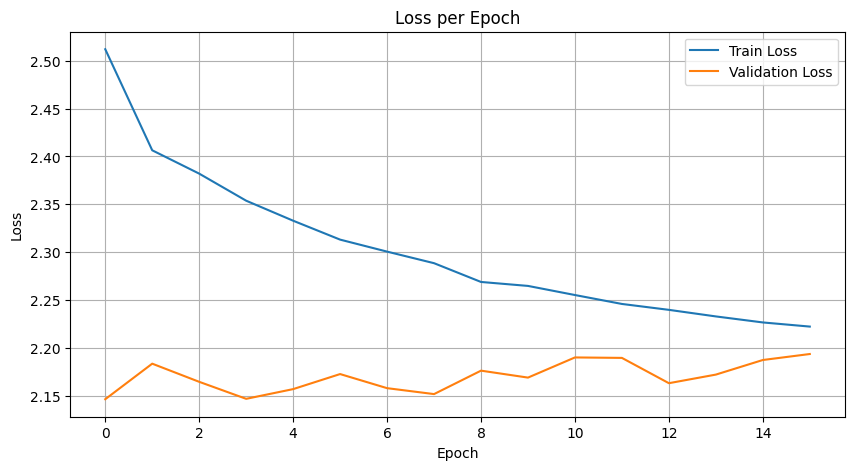

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 5))

# ax2 = ax1.twinx()

train_loss = history.history['loss']
val_loss = history.history['val_loss']

ax1.plot(train_loss, label='Train Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# train_acc = history.history['f1_score']
# val_acc = history.history['val_f1_score']

# ax2.plot(train_acc, label='Train F1', linestyle="dashed")
# ax2.plot(val_acc, label='Validation F1', linestyle="dashed")
# ax2.set_ylabel('F1')
# ax2.legend()

plt.title('Loss per Epoch')
plt.grid(True)
# plt.savefig("5_layer_20n_0_0001_lr_no_dropout.png",bbox_inches="tight",dpi=300)
plt.show()

In [ ]:
n_test = int(len(train_table) * 1/7)
test_files = rng.choice(os.listdir(test_dir),n_test)
test_lcs = [ASASSN_Lightcurve.from_dat_file(join(test_dir,f)) for f in test_files if os.path.isfile(join(test_dir,f))]

In [ ]:
test_lc_ids = [lc.id for lc in test_lcs]
mangled_tab_ids = [i.replace("+","_").replace("-","_").replace(" ","_").replace(".","_") for i in test_table["ID"]]
test_table["mangled_id"] = mangled_tab_ids
joiner = Table(data={"mangled_id":test_lc_ids})
test_table = tabjoin(joiner,test_table)
sort_idx = np.argsort(test_table["mangled_id"])
sorted_arr2 = test_table["mangled_id"][sort_idx]
positions = np.searchsorted(sorted_arr2, test_lc_ids)
reorder_indices = sort_idx[positions]
test_table =test_table[reorder_indices]
test_table["class_id"] = f(test_table["class"])
y_test = to_categorical(a(test_table["class_id"]), nb_classes)

In [ ]:
test_series = []
for lc in test_lcs:
  mags, times = a(lc.mag, dtype=np.float64), a(lc.times, dtype=np.float64) #, a(lc.abs_mag_err, dtype=np.float32)
  nan_mask = np.isnan(mags) | np.isnan(times)
  inf_mask = np.isinf(mags) | np.isinf(times)
  mask = nan_mask | inf_mask
  n_nan = len(np.where(mask)[0])
  if n_nan:
    print(f"filling {n_nan} nan/inf vals")
  mags[mask] = PAD_VALUE
  times[mask] = PAD_VALUE
  # errs[mask] = PAD_VALUE
  test_series.append(a([mags,times]).T)

x_test = np.empty((len(test_series), max_len, num_features), dtype=np.float64)
x_test.fill(PAD_VALUE)
for i, s in enumerate(test_series):
    x_test[i, :s.shape[0], :] = s[:max_len]
print(x_test.shape)

(6350, 2419, 2)


In [ ]:
test_loss, test_accuracy, test_f1 = model.evaluate(x_test,y_test)

199/199 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.5051 - f1_score: 0.3391 - loss: 2.1453


In [ ]:
probas = model.predict(x_test)
preds  = np.argmax(probas,axis=1)
Y_test_dense = np.argmax(y_test, axis=1)

199/199 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step


In [ ]:
print("Accuracy:",accuracy_score(Y_test_dense,preds))
print("Precision:",precision_score(Y_test_dense,preds,average="macro"))
print("Recall:",recall_score(Y_test_dense,preds,average="macro"))
f1 = f1_score(Y_test_dense,preds,average="macro")
print("F1:",f1)

Accuracy: 0.507244094488189
Precision: 0.056360454943132104
Recall: 0.1111111111111111
F1: 0.07478610153356785


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
id_to_class = dict(zip(np.arange(len(classes)),classes))
def formatter(x, pos):
  return id_to_class[int(x+0.5)-1]

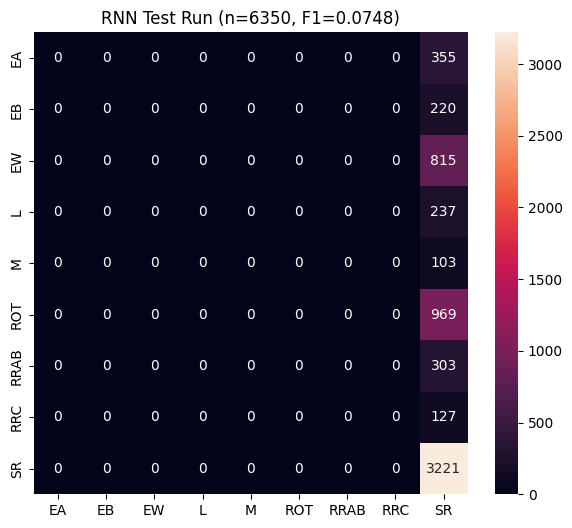

In [ ]:
conf = confusion_matrix(Y_test_dense,preds)
plt.figure(figsize=(7,6))
plt.title(f"RNN Test Run (n={len(y_test)}, F1={f1:.4f})")
_=sns.heatmap(conf,annot=True,fmt='d')
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.savefig("/content/rnn_confusion_matrix.png",dpi=300,bbox_inches="tight")